In [84]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.express as px

from scipy.io import arff
from sklearn import cluster
from sklearn import metrics
from sklearn import neighbors
import hdbscan

## 2D

In [145]:
df2d = pd.read_csv("./dataset/tr.data", sep=" ", names=["x", "y"])

<AxesSubplot:xlabel='x', ylabel='y'>

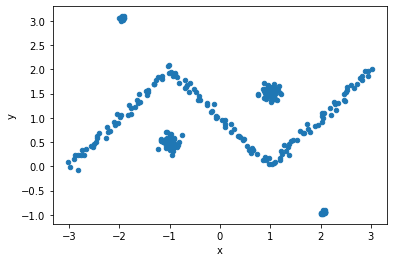

In [143]:
df2d.plot.scatter(x="x", y="y")

### k-Means on 2D datasets

In [71]:
min_score = 1 # Assumed upper bound for DB index (lower is better)
score = 1.1   # Initial score
n_clust = 2   # There must be at least two clusters 

results_DBI = []
times_DBI = []
kmeans = 1
best_kmeans = 1

# or just do 2-30 or something
#while score < (min_score * 1.423):
while n_clust < 20:    
    time_start = time.time()
    
    kmeans = cluster.KMeans(n_clusters=n_clust, init='k-means++').fit(df2d)
    
    time_post_cluster = time.time()
    
    score = metrics.davies_bouldin_score(df2d, kmeans.labels_)
    
    time_post_score = time.time()
    
    if score < min_score:
        min_score = score
        best_kmeans = kmeans
    
    results_DBI.append((n_clust, score))
    times_DBI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = min(results_DBI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_DBI[-1][2]-times_DBI[0][0]} seconds to figure that out. ({len(results_DBI)} iterations)")

I determine the number of clusters to be: 7.
It took me 0.5659527778625488 seconds to figure that out. (18 iterations)


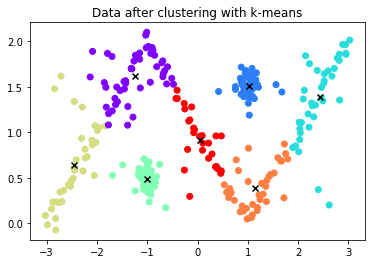

In [72]:
center_x = [point[0] for point in best_kmeans.cluster_centers_]
center_y = [point[1] for point in best_kmeans.cluster_centers_]

plt.scatter(df2d["x"], df2d["y"], c=best_kmeans.labels_, cmap='rainbow')
plt.scatter(center_x, center_y, marker="x", c="#000")
plt.title("Data after clustering with k-means")
plt.show()

### Agglomerative clustering on 2D datasets

In [119]:
min_score = 1 # Assumed upper bound for DB index (lower is better)
score = 1.1   # Initial score
n_clust = 2   # There must be at least two clusters 

results_DBI = []
times_DBI = []
agglo = 1
best_agglo = 1

# or just do 2-30 or something
#while score < (min_score * 1.423):
while n_clust < 20:
    time_start = time.time()
    
    agglo = cluster.AgglomerativeClustering(n_clusters=n_clust, linkage='ward').fit(df2d)
    
    time_post_cluster = time.time()
    
    score = metrics.davies_bouldin_score(df2d, agglo.labels_)
    
    time_post_score = time.time()
    
    if score < min_score:
        min_score = score
        best_agglo = agglo
    
    results_DBI.append((n_clust, score))
    times_DBI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = min(results_DBI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_DBI[-1][2]-times_DBI[0][0]} seconds to figure that out. ({len(results_DBI)} iterations)")

I determine the number of clusters to be: 5.
It took me 27.509113788604736 seconds to figure that out. (18 iterations)


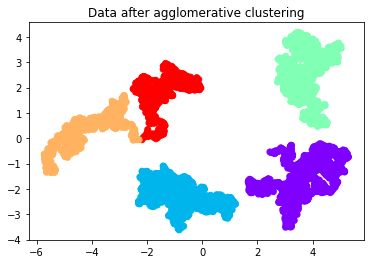

In [120]:
plt.scatter(df2d["x"], df2d["y"], c=best_agglo.labels_, cmap='rainbow')
plt.title("Data after agglomerative clustering")
plt.show()

### DBSCAN on 2D datasets

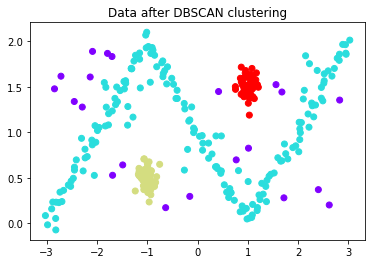

In [137]:
dbscan = cluster.DBSCAN(eps=0.3, min_samples=7).fit(df2d)

plt.scatter(df2d["x"], df2d["y"], c=dbscan.labels_, cmap='rainbow')
plt.title("Data after DBSCAN clustering")
plt.show()

### HDBSCAN on 2D datasets

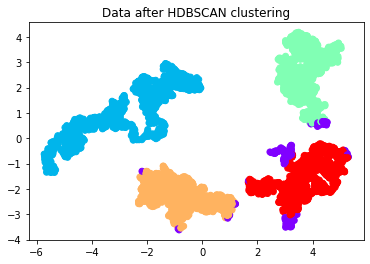

In [150]:
maa = hdbscan.HDBSCAN(min_cluster_size=200).fit(df2d)

plt.scatter(df2d["x"], df2d["y"], c=maa.labels_, cmap='rainbow')
plt.title("Data after HDBSCAN clustering")
plt.show()

## 3D

In [105]:
df3d = pd.read_csv("./dataset/a.data", sep="\t", names=["x", "y", "z"])

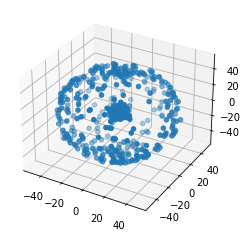

In [106]:
threedee = plt.figure()
ax = threedee.add_subplot(projection="3d")
ax.scatter(df3d["x"], df3d["y"], df3d["z"])
plt.show()

## k-Means on 3D datasets

In [107]:
min_score = 1 # Assumed upper bound for DB index (lower is better)
score = 1.1   # Initial score
n_clust = 2   # There must be at least two clusters 

results_DBI = []
times_DBI = []
kmeans = 1
best_kmeans = 1

# or just do 2-30 or something
#while score < (min_score * 1.423):
while n_clust < 20:    
    time_start = time.time()
    
    kmeans = cluster.KMeans(n_clusters=n_clust, init='k-means++').fit(df3d)
    
    time_post_cluster = time.time()
    
    score = metrics.davies_bouldin_score(df3d, kmeans.labels_)
    
    time_post_score = time.time()
    
    if score < min_score:
        min_score = score
        best_kmeans = kmeans
    
    results_DBI.append((n_clust, score))
    times_DBI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = min(results_DBI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_DBI[-1][2]-times_DBI[0][0]} seconds to figure that out. ({len(results_DBI)} iterations)")

I determine the number of clusters to be: 15.
It took me 0.7685451507568359 seconds to figure that out. (18 iterations)


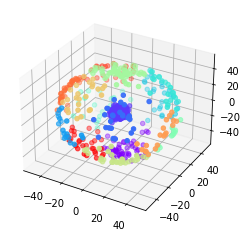

In [108]:
center_x = [point[0] for point in best_kmeans.cluster_centers_]
center_y = [point[1] for point in best_kmeans.cluster_centers_]
center_z = [point[2] for point in best_kmeans.cluster_centers_]

# plt.scatter(df2d["x"], df2d["y"], c=best_kmeans.labels_, cmap='rainbow')
# plt.scatter(center_x, center_y, marker="x", c="#000")
# plt.title("Data after clustering with k-means")
# plt.show()

threedee_post = plt.figure()
ax_post = threedee_post.add_subplot(projection="3d")
ax_post.scatter(df3d["x"], df3d["y"], df3d["z"], c=best_kmeans.labels_, cmap='rainbow')
plt.show()

In [109]:
fig = px.scatter_3d(df3d, x="x", y="y", z="z", color=best_kmeans.labels_)
fig.show()